In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))

In [3]:
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])

In [4]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
2765,../input/stage1_train/08151b19806eebd58e5acec7...,08151b19806eebd58e5acec7e138dbfbb1761f41a1ab96...,masks,train,stage1
4206,../input/stage1_train/3b3f516ebc9a16cff287a5ff...,3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba...,masks,train,stage1


In [5]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

CPU times: user 28.4 s, sys: 1.63 s, total: 30.1 s
Wall time: 30.1 s


In [6]:
X=train_img_df['images']
Y=train_img_df['masks']

In [7]:
from skimage.transform import resize

l=X.shape[0]
images=[None]*l
masks=[None]*l
for i in range(l):
    images[i]=resize(X[i],(256, 256,3), mode='constant', preserve_range=True)
    masks[i]=resize(Y[i],(256, 256,1), mode='constant', preserve_range=True)
    masks[i]=masks[i].astype(int)
    
images=np.asarray(images)
masks=np.asarray(masks)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [9]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

In [56]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [67]:
datagen.fit(images)

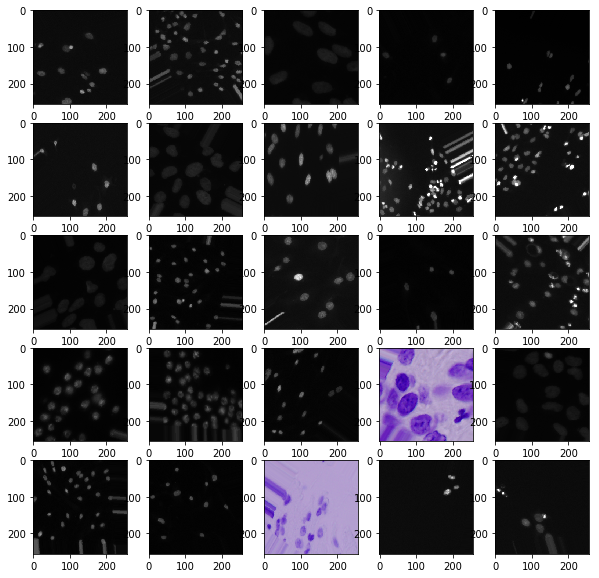

In [132]:
i=1
k=25
fig = plt.figure(figsize=(10, 10)) 
for X_batch in datagen.flow(images, batch_size=1,seed=7):
    #fig = plt.figure(figsize=(8, 6)) 
    plt.subplot(5,5,i)
    plt.imshow(X_batch[0])
    i+=1
    if i>k:
        break
plt.show()

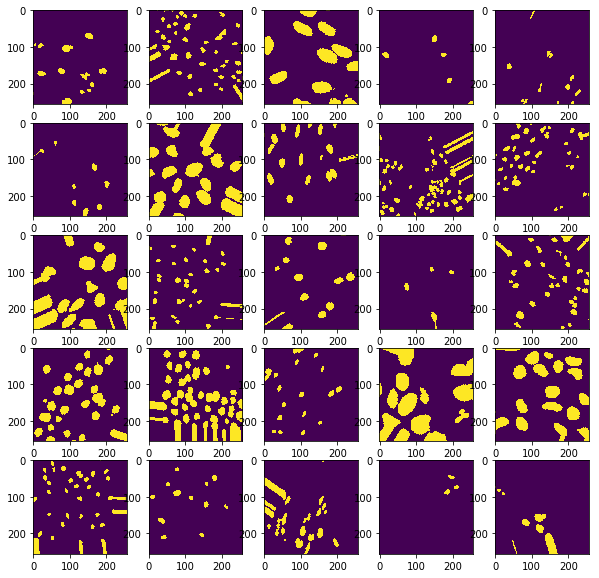

In [133]:
i=1
k=25
fig = plt.figure(figsize=(10, 10)) 

for y_batch in datagen.flow(masks, batch_size=1,seed=7):
    plt.subplot(5,5,i)
    plt.imshow(y_batch[0][:,:,0])
    i+=1
    if i>k:
        break
plt.show()

In [116]:
y_batch[0].shape

(256, 256, 1)

In [134]:
%%time
i=1
k=600
#fig = plt.figure(figsize=(10, 10)) 
images_aug=images
for X_batch in datagen.flow(images, batch_size=1,seed=1):
    x=X_batch[0]
    x = x.reshape((1,) + x.shape)
    images_aug=np.vstack((images_aug,x))
    i+=1
    if i>k:
        break


In [135]:
images_aug.shape

(1270, 256, 256, 3)

In [136]:
%%time
i=1
k=600
#fig = plt.figure(figsize=(10, 10)) 
masks_aug=masks
for y_batch in datagen.flow(masks, batch_size=1,seed=1):
    y=y_batch[0]
    y = y.reshape((1,) + y.shape)
    masks_aug=np.vstack((masks_aug,y))
    i+=1
    if i>k:
        break


CPU times: user 35.8 s, sys: 15.8 s, total: 51.6 s
Wall time: 51.6 s


In [137]:
masks_aug.shape

(1270, 256, 256, 1)

In [145]:
import tensorflow as tf

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [179]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras import backend as K
K.clear_session()

# Build U-Net model
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 8)   224         lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 8)   584         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [180]:
model.fit(images_aug,masks_aug,validation_split=0.1, batch_size=8, epochs=5)

Train on 1143 samples, validate on 127 samples
Epoch 1/5
1143/1143 [==============================] - 183s - loss: 0.4731 - my_iou_metric: 0.0000e+00 - val_loss: 0.2659 - val_my_iou_metric: 0.0000e+00
Epoch 2/5
1143/1143 [==============================] - 186s - loss: 0.2149 - my_iou_metric: 3.4996e-04 - val_loss: 0.1445 - val_my_iou_metric: 0.0000e+00
Epoch 3/5
1143/1143 [==============================] - 187s - loss: 0.1472 - my_iou_metric: 0.0131 - val_loss: 0.1231 - val_my_iou_metric: 0.0063
Epoch 4/5
1143/1143 [==============================] - 189s - loss: 0.1240 - my_iou_metric: 0.0284 - val_loss: 0.1070 - val_my_iou_metric: 0.0457
Epoch 5/5
1143/1143 [==============================] - 190s - loss: 0.1057 - my_iou_metric: 0.0352 - val_loss: 0.0972 - val_my_iou_metric: 0.0323


In [181]:
model.fit(images_aug,masks_aug,validation_split=0.1, batch_size=8, epochs=10)

Train on 1143 samples, validate on 127 samples
Epoch 1/10
1143/1143 [==============================] - 188s - loss: 0.0978 - my_iou_metric: 0.0463 - val_loss: 0.0987 - val_my_iou_metric: 0.0496
Epoch 2/10
1143/1143 [==============================] - 193s - loss: 0.0889 - my_iou_metric: 0.0507 - val_loss: 0.0885 - val_my_iou_metric: 0.0606
Epoch 3/10
1143/1143 [==============================] - 199s - loss: 0.0868 - my_iou_metric: 0.0530 - val_loss: 0.0850 - val_my_iou_metric: 0.0472
Epoch 4/10
1143/1143 [==============================] - 197s - loss: 0.0840 - my_iou_metric: 0.0583 - val_loss: 0.0935 - val_my_iou_metric: 0.0331
Epoch 5/10
1143/1143 [==============================] - 201s - loss: 0.0792 - my_iou_metric: 0.0571 - val_loss: 0.0796 - val_my_iou_metric: 0.0512
Epoch 6/10
1143/1143 [==============================] - 200s - loss: 0.0782 - my_iou_metric: 0.0663 - val_loss: 0.0787 - val_my_iou_metric: 0.0409
Epoch 7/10
1143/1143 [==============================] - 200s - loss: 0.

In [182]:
early_stop = EarlyStopping(monitor='val_my_iou_metric', patience=20, verbose=1)
model.fit(images_aug,masks_aug,validation_split=0.1, batch_size=8, epochs=10,callbacks=[early_stop])

Train on 1143 samples, validate on 127 samples
Epoch 1/10
1143/1143 [==============================] - 198s - loss: 0.0695 - my_iou_metric: 0.0729 - val_loss: 0.0752 - val_my_iou_metric: 0.0591
Epoch 2/10
1143/1143 [==============================] - 193s - loss: 0.0685 - my_iou_metric: 0.0680 - val_loss: 0.0795 - val_my_iou_metric: 0.0559
Epoch 3/10
1143/1143 [==============================] - 186s - loss: 0.0677 - my_iou_metric: 0.0698 - val_loss: 0.0749 - val_my_iou_metric: 0.0638
Epoch 4/10
1143/1143 [==============================] - 189s - loss: 0.0665 - my_iou_metric: 0.0744 - val_loss: 0.0719 - val_my_iou_metric: 0.0693
Epoch 5/10
1143/1143 [==============================] - 190s - loss: 0.0644 - my_iou_metric: 0.0761 - val_loss: 0.0759 - val_my_iou_metric: 0.0772
Epoch 6/10
1143/1143 [==============================] - 191s - loss: 0.0629 - my_iou_metric: 0.0753 - val_loss: 0.0750 - val_my_iou_metric: 0.0772
Epoch 7/10
1143/1143 [==============================] - 188s - loss: 0.

In [221]:
model.fit(images_aug,masks_aug,validation_split=0.1, batch_size=8, epochs=20)

Train on 1143 samples, validate on 127 samples
Epoch 1/20
 424/1143 [==========>...................] - ETA: 126s - loss: 0.0400 - my_iou_metric: 0.1087

KeyboardInterrupt: 

In [211]:
early_stop = EarlyStopping(monitor='val_my_iou_metric', patience=20, verbose=1)
model.fit(images_aug,masks_aug,validation_split=0.1, batch_size=8, epochs=10,callbacks=[early_stop])

Train on 1143 samples, validate on 127 samples
Epoch 1/10
1143/1143 [==============================] - 190s - loss: 0.0448 - my_iou_metric: 0.1044 - val_loss: 0.0885 - val_my_iou_metric: 0.0661
Epoch 2/10
1143/1143 [==============================] - 195s - loss: 0.0437 - my_iou_metric: 0.1090 - val_loss: 0.0852 - val_my_iou_metric: 0.0677
Epoch 3/10
1143/1143 [==============================] - 202s - loss: 0.0446 - my_iou_metric: 0.1074 - val_loss: 0.0894 - val_my_iou_metric: 0.0874
Epoch 4/10
1143/1143 [==============================] - 202s - loss: 0.0433 - my_iou_metric: 0.1021 - val_loss: 0.0850 - val_my_iou_metric: 0.0630
Epoch 5/10
1143/1143 [==============================] - 202s - loss: 0.0418 - my_iou_metric: 0.1088 - val_loss: 0.0873 - val_my_iou_metric: 0.0882
Epoch 6/10
1143/1143 [==============================] - 201s - loss: 0.0413 - my_iou_metric: 0.1060 - val_loss: 0.0860 - val_my_iou_metric: 0.0685
Epoch 7/10
1143/1143 [==============================] - 203s - loss: 0.

KeyboardInterrupt: 

In [212]:
i=100
p=model.predict(images_aug[i:i+1,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [213]:
a=np.where(p>0.5,1,0)

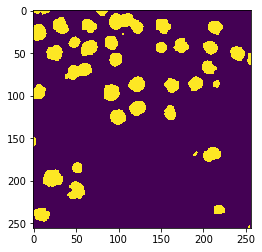

In [214]:
plt.imshow(a)


In [215]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
b = np.where(p > thresh_val, 1, 0)

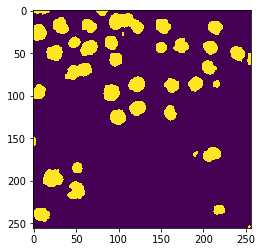

In [216]:
plt.imshow(b)

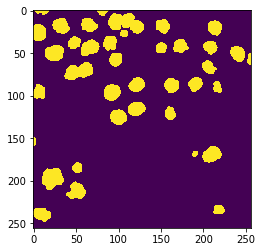

In [217]:
plt.imshow(masks_aug[i,:,:,0])

In [218]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [219]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    #thresh_val = threshold_otsu(p)
    mask = np.where(p > 0.5, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [220]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnetAug1.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

9.7062869072


In [201]:
len(df)

2536